In [1]:
import pandas as pd

In [2]:
test_data=pd.read_csv("kaggle/test.csv")
train_data=pd.read_csv("kaggle/train.csv")

In [3]:
test_data.shape
train_data.shape

(1460, 81)

In [4]:
train_data.iloc[0:4,0:-1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml


In [5]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [6]:
numeric_features=all_features.dtypes[all_features.dtypes != 'object'].index

In [7]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x-x.mean())/x.std())

In [8]:
all_features = all_features.fillna(all_features.mean())

In [9]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [10]:
train_num=train_data.shape[0]

In [11]:
train_num

1460

In [12]:
from mxnet import nd

train_features = nd.array(all_features[0:train_num].values)
test_features = nd.array(all_features[train_num:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape(-1,1)
train_labels.shape

(1460, 1)

In [13]:
#save all the files for later usague


from io import StringIO
import boto3

csv_buffer = StringIO()

key_csv_train='sorted_features.csv'
key_csv_validation='sorted_labels.csv'

all_features[0:train_num].to_csv(key_csv_train,header=False,index=False)
train_data.SalePrice.to_csv(key_csv_validation,header=False,index=False)



#df.to_csv(csv_buffer)
boto3.resource('s3').Bucket('dongaws').upload_file(key_csv_train,'kaggle/train/{}'.format(key_csv_train))
boto3.resource('s3').Bucket('dongaws').upload_file(key_csv_validation,'kaggle/train/{}'.format(key_csv_validation))

s3_train_data_csv = 's3://dongaws/kaggle/train/{}'.format(key_csv_train)
s3_validation_data_csv = 's3://dongaws/kaggle/train/{}'.format(key_csv_validation)

print(s3_train_data_csv)
print(s3_validation_data_csv)

s3://dongaws/kaggle/train/sorted_features.csv
s3://dongaws/kaggle/train/sorted_labels.csv


In [14]:
from mxnet.gluon import loss as gloss, nn, data as gdata
from mxnet import autograd, gluon, init

loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [15]:
def log_rmse(net, train_features, train_labels):
    # 将小于 1 的值设成 1，使得取对数时数值更稳定。
    clipped_preds = nd.clip(net(train_features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), train_labels.log()).mean())
    return rmse.asscalar()

In [16]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了 Adam 优化算法。
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [17]:
num_epochs, lr, weight_decay, batch_size = 100, 5, 0, 64
net = get_net()
train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)

([3.5461962,
  2.8619206,
  2.4655416,
  2.1872015,
  1.9707569,
  1.7976907,
  1.6517646,
  1.5271363,
  1.4182231,
  1.3220257,
  1.2357688,
  1.1580396,
  1.0872607,
  1.0228029,
  0.96335435,
  0.9084028,
  0.85748118,
  0.81057829,
  0.76703912,
  0.72589898,
  0.68757683,
  0.65192145,
  0.61830264,
  0.58698475,
  0.55723989,
  0.52929002,
  0.50343162,
  0.47882292,
  0.4557187,
  0.43382418,
  0.41323856,
  0.39407697,
  0.37597486,
  0.35907671,
  0.3430486,
  0.3283087,
  0.31438544,
  0.30151179,
  0.28957179,
  0.27828068,
  0.26779529,
  0.25800985,
  0.24906759,
  0.24075985,
  0.23305367,
  0.22613624,
  0.21988958,
  0.21399584,
  0.20889831,
  0.20395978,
  0.19948201,
  0.19554548,
  0.19207025,
  0.18882802,
  0.18602546,
  0.18350029,
  0.1812548,
  0.17919526,
  0.1773701,
  0.17581674,
  0.17445605,
  0.17320892,
  0.17214693,
  0.17117518,
  0.1703665,
  0.16962475,
  0.16902186,
  0.16847931,
  0.16803956,
  0.16765267,
  0.16733673,
  0.166963,
  0.16674161,
 

In [18]:
'''
#split the data into training and validate

split_train = int(len(train_features) * 0.8)

train_X=all_features[0:train_data.shape[0]][0:split_train]
train_Y=train_data.SalePrice[0:split_train]

validate_X=all_features[0:train_data.shape[0]][split_train:]
validate_Y=train_data.SalePrice[split_train:]
'''

'\n#split the data into training and validate\n\nsplit_train = int(len(train_features) * 0.8)\n\ntrain_X=all_features[0:train_data.shape[0]][0:split_train]\ntrain_Y=train_data.SalePrice[0:split_train]\n\nvalidate_X=all_features[0:train_data.shape[0]][split_train:]\nvalidate_Y=train_data.SalePrice[split_train:]\n'

In [19]:
'''
import io
import sagemaker.amazon.common as smac


key = 'train.data'
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_Y).astype('float32'))
buf.seek(0)


boto3.resource('s3').Bucket('dongaws').Object(os.path.join('kaggle','train_recordio',key)).upload_fileobj(buf)

s3_train_data = 's3://dongaws/kaggle/train/{}'.format(key)
'''

"\nimport io\nimport sagemaker.amazon.common as smac\n\n\nkey = 'train.data'\nbuf = io.BytesIO()\nsmac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_Y).astype('float32'))\nbuf.seek(0)\n\n\nboto3.resource('s3').Bucket('dongaws').Object(os.path.join('kaggle','train_recordio',key)).upload_fileobj(buf)\n\ns3_train_data = 's3://dongaws/kaggle/train/{}'.format(key)\n"

In [20]:
'''
key = 'validation.data'
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(validate_X).astype('float32'), np.array(validate_Y).astype('float32'))
buf.seek(0)

boto3.resource('s3').Bucket('dongaws').Object(os.path.join('kaggle','validation_recordio',key)).upload_fileobj(buf)
s3_validation_data = 's3://dongaws/kaggle/validation/{}'.format(key)
'''

"\nkey = 'validation.data'\nbuf = io.BytesIO()\nsmac.write_numpy_to_dense_tensor(buf, np.array(validate_X).astype('float32'), np.array(validate_Y).astype('float32'))\nbuf.seek(0)\n\nboto3.resource('s3').Bucket('dongaws').Object(os.path.join('kaggle','validation_recordio',key)).upload_fileobj(buf)\ns3_validation_data = 's3://dongaws/kaggle/validation/{}'.format(key)\n"

In [35]:
import os
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role
import numpy as np

sagemaker_session = sagemaker.Session()

role = get_execution_role()

m = MXNet("price.py", 
          role=role, 
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge', 
          framework_version='1.3.0',
          hyperparameters = {
              'batch_size' : 64,
              'epochs': 100,
              'learning_rate': 0.1,
              'weight_decay':0
          })
m.fit("s3://dongaws/kaggle/train/")

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-12-31-13-06-33-746


2018-12-31 13:06:35 Starting - Starting the training job...
2018-12-31 13:06:39 Starting - Launching requested ML instances......
2018-12-31 13:07:42 Starting - Preparing the instances for training......
2018-12-31 13:09:01 Downloading - Downloading input data
2018-12-31 13:09:01 Training - Training image download completed. Training in progress.
2018-12-31 13:09:01 Uploading - Uploading generated training model
2018-12-31 13:08:51,615 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2018-12-31 13:08:51,619 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2018-12-31 13:08:51,641 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_INPUT_DIR': '/opt/ml/input', 'SM_USER_ENTRY_POINT': 'price.py', 'SM_TRAINING_ENV': '{"additional_framework_parameters":{},"channel_input_dirs":{"training":"/opt/ml/input/data/training"},"current_host":"algo-1","framework_module":"sagemaker_mxnet_container.training:main","ho


2018-12-31 13:09:07 Completed - Training job completed
Billable seconds: 29


In [36]:
price_predictor = m.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')


INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-12-31-13-06-33-746
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-12-31-13-06-33-746


--------------------------------------------------------------!

In [37]:
#test_features.shape
result = price_predictor.predict(test_features.asnumpy())

In [41]:
print(len(result))

1459


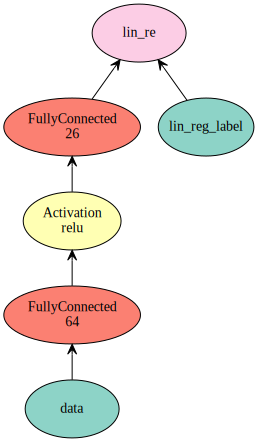

In [80]:
import mxnet as mx

label = mx.symbol.Variable('lin_reg_label')
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=64)
net = mx.sym.Activation(net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=26)
net = mx.sym.LinearRegressionOutput(net, label=label, name='lin_re')
mx.viz.plot_network(net, node_attrs={"shape":"oval","fixedsize":"false"})

In [81]:
split_train = int(len(train_features) * 0.8)


train_iter = mx.io.NDArrayIter(train_features[:split_train, :], train_labels.reshape(-1,)[0:split_train], batch_size, shuffle=True,label_name='lin_reg_label')
val_iter = mx.io.NDArrayIter(train_features[split_train:, :], train_labels.reshape(-1,)[split_train:], batch_size,label_name='lin_reg_label')


In [82]:
print(train_labels.reshape(-1,).shape)

(1460,)


In [83]:
model = mx.mod.Module(
    symbol = net ,
    data_names=['data'],
    label_names = ['lin_reg_label']# network structure
)

In [84]:
model.fit(train_iter,
        eval_data=val_iter,
        optimizer='sgd',
        optimizer_params={'learning_rate':0.1},
        eval_metric='mse',
        batch_end_callback = mx.callback.Speedometer(1, 400),
        num_epoch=7)

RuntimeError: simple_bind error. Arguments:
data: (64, 331)
lin_reg_label: (64,)
Error in operator lin_re: Shape inconsistent, Provided=[64], inferred shape=[64,26]